#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [90]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [91]:
# 데이터 가져오기
path = '/Users/soeon/Desktop/KT 에이블스쿨/미니프로젝트/3차/data01_train.csv'
data = pd.read_csv(path)

# 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [92]:
# 'subject' 칼럼 삭제
data = data.drop(columns = ['subject'])

In [93]:
# 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [94]:
# 형태 확인
data.shape

(5881, 562)

In [95]:
# 기초통계량
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",5881.0,0.009340,0.608190,-1.000000,-0.481718,0.011448,0.499857,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157


In [96]:
# 정보확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [97]:
# 범주의 종류
data['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [98]:
# 범주별 빈도수
data['Activity'].value_counts()

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

In [99]:
# 범주별 비율
data['Activity'].value_counts(normalize = True) * 100

Activity
LAYING                18.959361
STANDING              18.483251
SITTING               17.548036
WALKING               16.969903
WALKING_UPSTAIRS      14.589356
WALKING_DOWNSTAIRS    13.450094
Name: proportion, dtype: float64

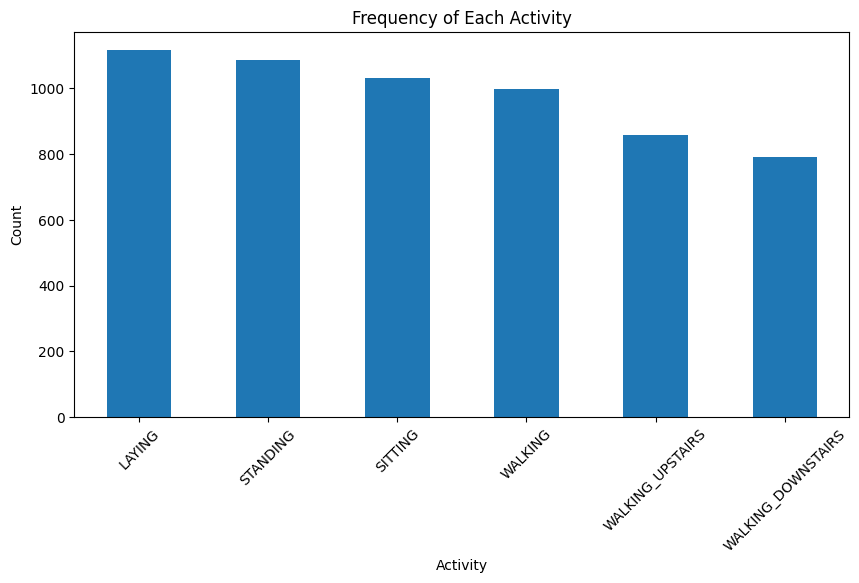

In [100]:
# 빈도수 시각화
plt.figure(figsize=(10, 5))
data['Activity'].value_counts().plot(kind='bar')
plt.title('Frequency of Each Activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [101]:
# 데이터 분리
target = 'Activity'

x = data.drop(columns=target)
y = data.loc[:, target]

# 7:3으로 train, val 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify = y, random_state=1)

#### 2) 모델링

In [102]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

# 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[335   0   0   0   0   0]
 [  0 288  21   0   0   1]
 [  0  10 316   0   0   0]
 [  0   0   0 293   6   1]
 [  0   0   0   4 230   3]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.97      0.93      0.95       310
          STANDING       0.94      0.97      0.95       326
           WALKING       0.98      0.98      0.98       300
WALKING_DOWNSTAIRS       0.97      0.97      0.97       237
  WALKING_UPSTAIRS       0.98      0.99      0.99       257

          accuracy                           0.97      1765
         macro avg       0.97      0.97      0.97      1765
      weighted avg       0.97      0.97      0.97      1765



#### 3) 변수 중요도 추출

In [103]:
# 특성 중요도 추출
importances = model.feature_importances_
feature_names = x_train.columns

# 특성 중요도 데이터프레임 생성
fi_df = plot_feature_importance(importances, feature_names, result_only=True)

# 상위 5개 변수 출력
top_5 = fi_df.head(5)
print("\nTop 5 Important Features:\n", top_5)

# 하위 5개 변수 출력
bottom_5 = fi_df.tail(5)
print("\nBottom 5 Important Features:\n", bottom_5)


Top 5 Important Features:
              feature_name  feature_importance
0    angle(X,gravityMean)            0.040292
1    tGravityAcc-mean()-X            0.029722
2  tGravityAcc-energy()-X            0.028632
3     tGravityAcc-min()-X            0.027835
4     tGravityAcc-min()-Y            0.025739

Bottom 5 Important Features:
                         feature_name  feature_importance
556  fBodyGyro-bandsEnergy()-49,64.1            0.000084
557              tGravityAcc-iqr()-Z            0.000078
558           tBodyGyroJerk-mean()-Z            0.000077
559             fBodyAccJerk-min()-Y            0.000070
560             fBodyAccJerk-iqr()-Y            0.000069


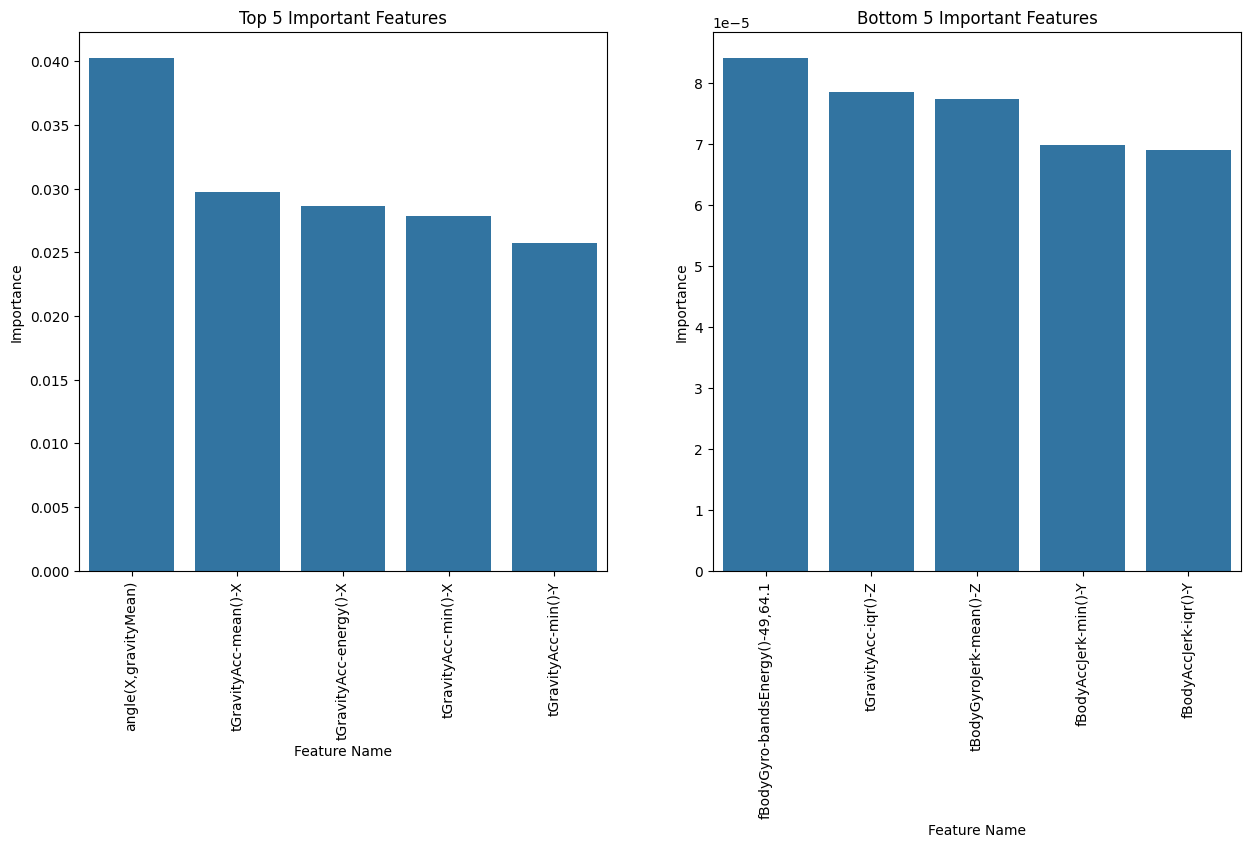

In [104]:
# 변수 중요도 시각화
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='feature_name', y='feature_importance', data=top_5)
plt.title('Top 5 Important Features')
plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.xticks(rotation=90) 

plt.subplot(1, 2, 2)
sns.barplot(x='feature_name', y='feature_importance', data=bottom_5)
plt.title('Bottom 5 Important Features')
plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.xticks(rotation=90) 

plt.show()

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [105]:
# 상위 5개
top_5

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.040292
1,tGravityAcc-mean()-X,0.029722
2,tGravityAcc-energy()-X,0.028632
3,tGravityAcc-min()-X,0.027835
4,tGravityAcc-min()-Y,0.025739


In [106]:
# 하위 5개
bottom_5

,feature_name,feature_importance
556,"fBodyGyro-bandsEnergy()-49,64.1",0.000084
557,tGravityAcc-iqr()-Z,0.000078
558,tBodyGyroJerk-mean()-Z,0.000077
559,fBodyAccJerk-min()-Y,0.000070
560,fBodyAccJerk-iqr()-Y,0.000069


* kdeplot 함수

In [107]:
# data => 사용할 데이터
# feature => 시각화할 변수명
# target => target 변수명

def kplot(data, feature, target):
    plt.figure(figsize=(10, 7))
    # kde plot
    # plt.subplot(2, 1, 1)
    sns.kdeplot(x = feature, data = data, hue = target, fill=True)
    plt.title(f'KDE Plot of {feature} by {target}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid()
    plt.show()

    # 히스토그램
    # plt.figure(figsize=(20,20))
    # plt.subplot(2, 1, 2)
    # sns.histplot(x = feature, data = data, hue = target, bins = 30)
    # plt.title(f'Histogram of {feature} by {target}')
    # plt.xlabel(feature)
    # plt.ylabel(target)
    # plt.grid()
    # plt.show()

#### 2) 상위 5개 변수에 대한 분석

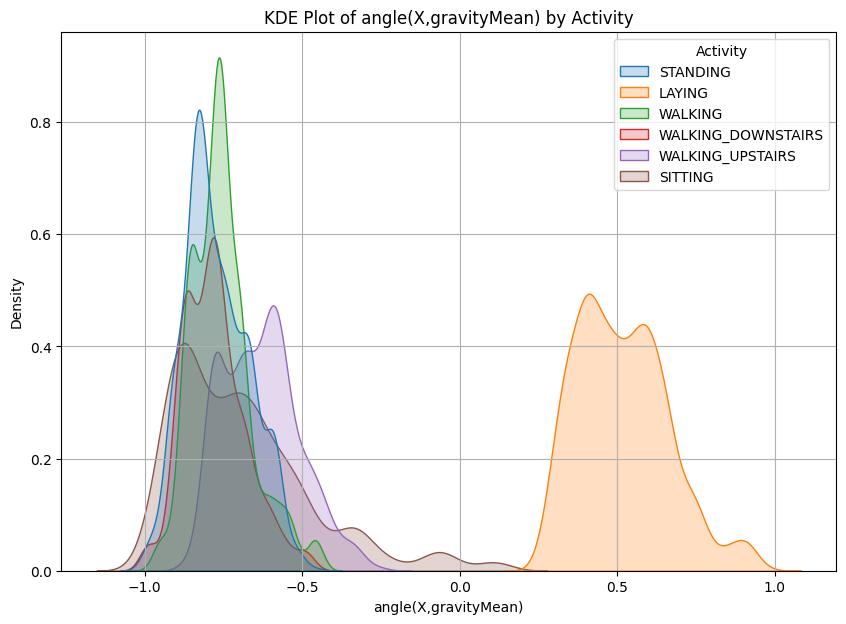

In [108]:
# 1등. angle(X,gravityMean)
# (X축 방향 - 중력가속도 평균) 벡터 사이의 각도
feature = 'angle(X,gravityMean)'
target = 'Activity'
kplot(data, feature, target)

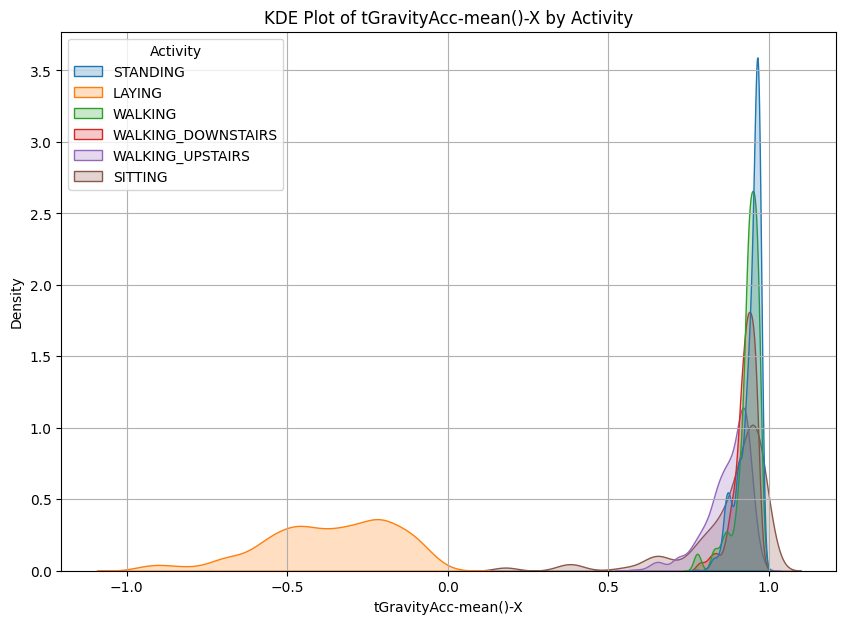

In [109]:
# 2등. tGravityAcc-mean()-X
# X축 방향 중력가속도 평균
feature = 'tGravityAcc-mean()-X'
target = 'Activity'
kplot(data, feature, target)

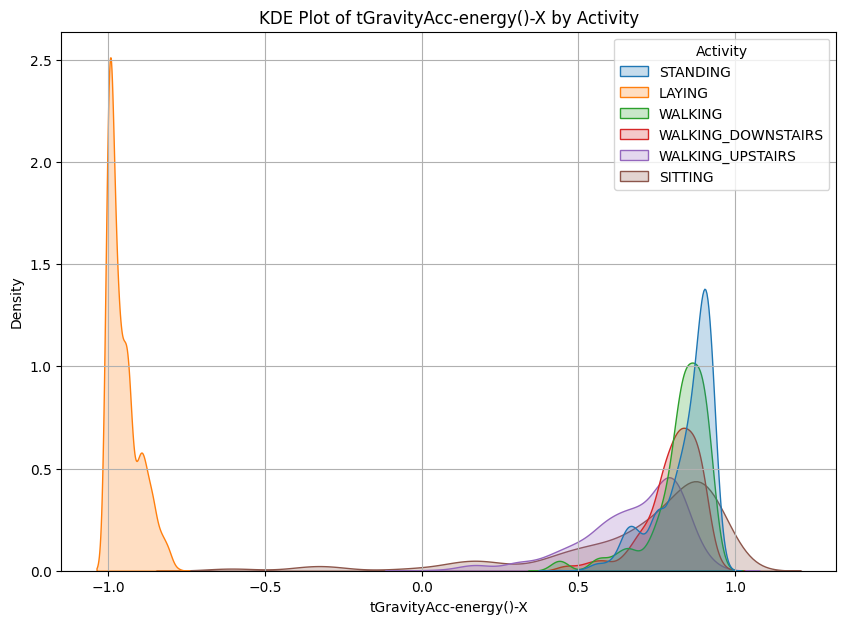

In [110]:
# 3등. tGravityAcc-energy()-X
# X축 방향 중력가속도 에너지 측정값
feature = 'tGravityAcc-energy()-X'
target = 'Activity'
kplot(data, feature, target)

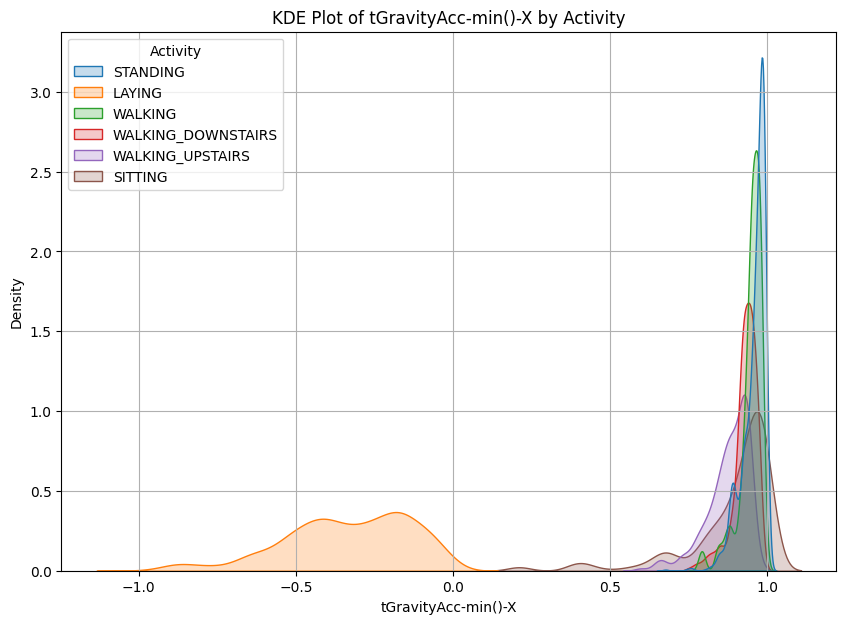

In [111]:
# 4등. tGravityAcc-min()-X
# X축 방향 중력가속도 최소값
feature = 'tGravityAcc-min()-X'
target = 'Activity'
kplot(data, feature, target)

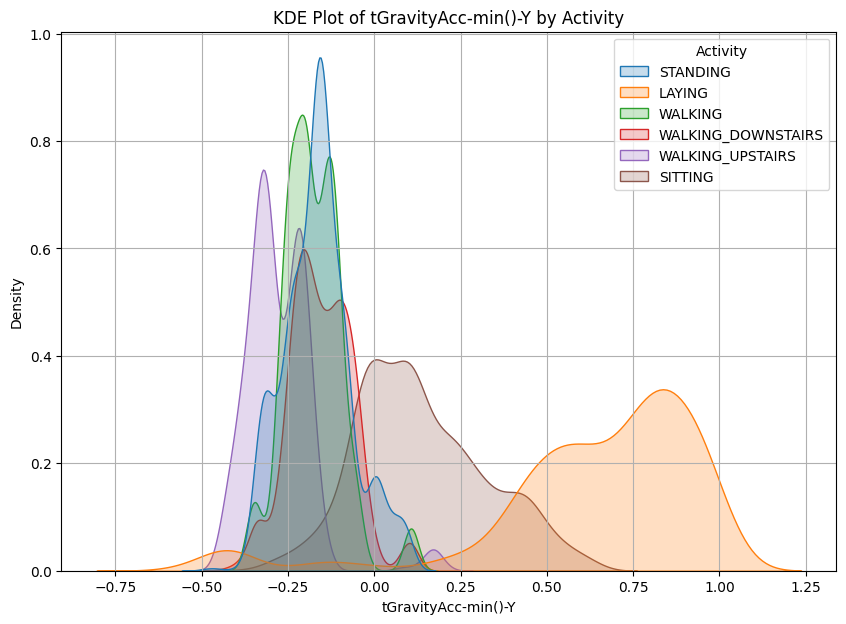

In [112]:
# 5등. tGravityAcc-min()-Y
# Y축 방향 중력가속도 최소값
feature = 'tGravityAcc-min()-Y'
target = 'Activity'
kplot(data, feature, target)

In [113]:
# LAYING처럼 특정 activity의 차이를 명확하게 볼 수 있는 변수들이 높은 중요도를 가지는 것으로 나타남
# box플롯을 보면 LAYING을 제외한 다른 변수들은 모두 범위가 많이 겹치게 나왔음
  # 눕는 거는 사람이 ㅡ 이렇게 눕게 되는데 나며지는 모두 ㅣ 이렇게 있어서...?
  # 가속도 센서와 관련된 변수들이 도출됨 => 선형가속도를 측정하기 때문에 유일하게 선형의 유형?이 다른 LYING이 특징적으로 나온 듯?

#### 3) 하위 5개 변수에 대한 분석

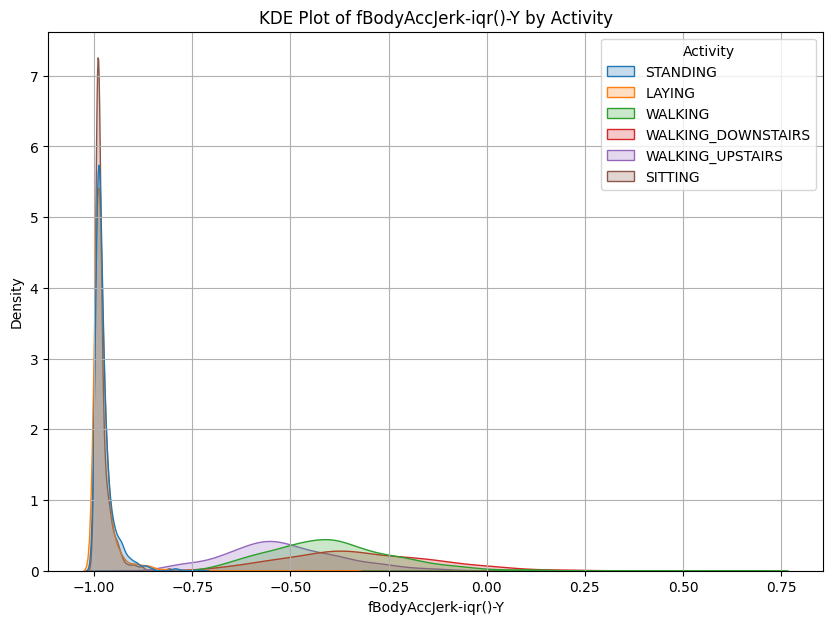

In [114]:
# 560등. fBodyAccJerk-iqr()-Y
# 고속퓨리에변환을 거친 Y축 방향 가속도변화비율 3사분위수 - 1사분위수
feature = 'fBodyAccJerk-iqr()-Y'
target = 'Activity'
kplot(data, feature, target)

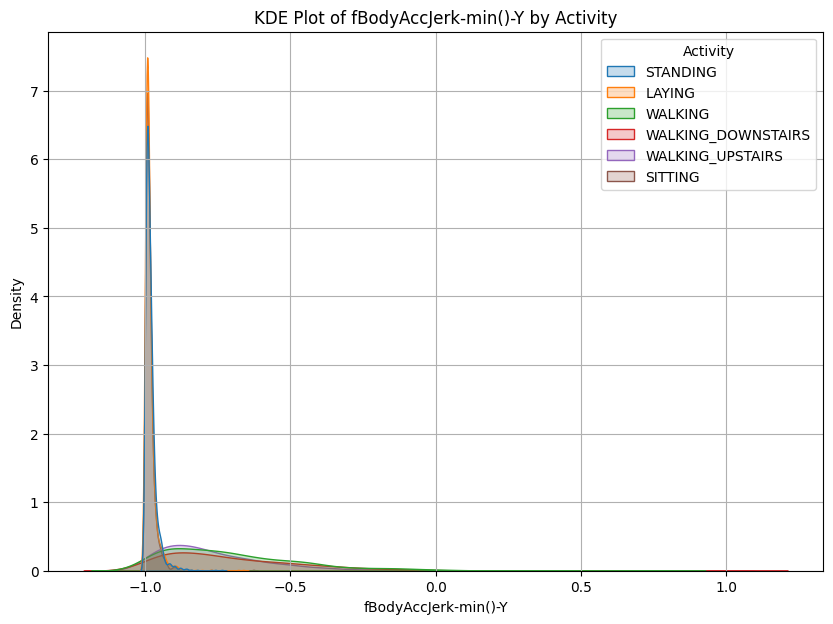

In [115]:
# 559등. fBodyAccJerk-min()-Y
# 고속퓨리에변환을 거친 Y축 방향 가속도변화비율 최소값
feature = 'fBodyAccJerk-min()-Y'
target = 'Activity'
kplot(data, feature, target)

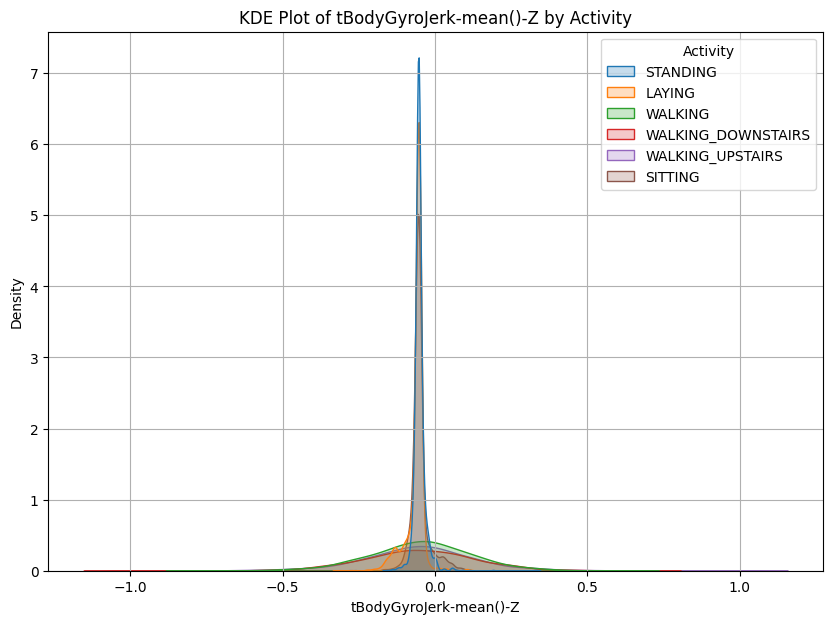

In [116]:
# 558등. tBodyGyroJerk-mean()-Z
# Z축 방향 각속도변화속도 평균
feature = 'tBodyGyroJerk-mean()-Z'
target = 'Activity'
kplot(data, feature, target)

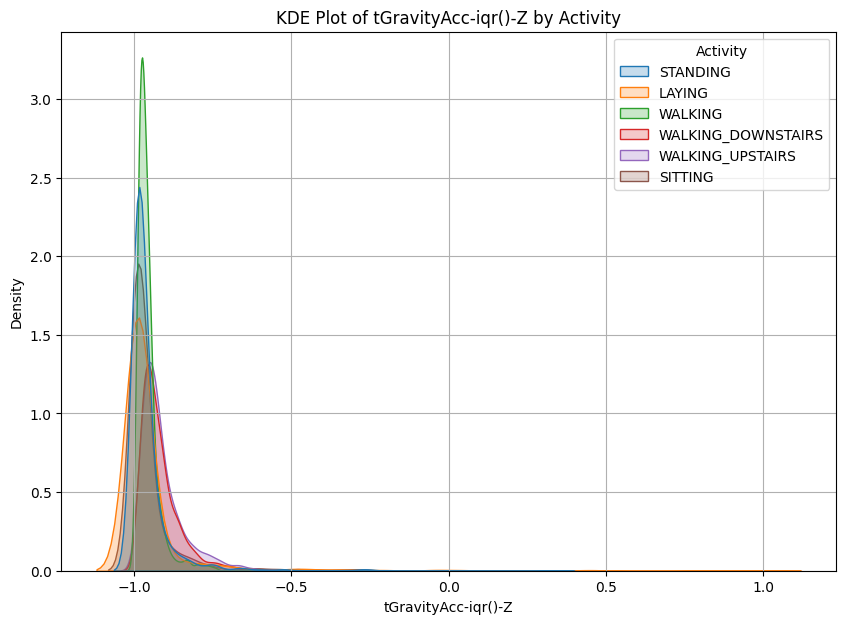

In [117]:
# 557등. tGravityAcc-iqr()-Z
# Z축 방향 중력가속도 3사분위수 - 1사분위수
feature = 'tGravityAcc-iqr()-Z'
target = 'Activity'
kplot(data, feature, target)

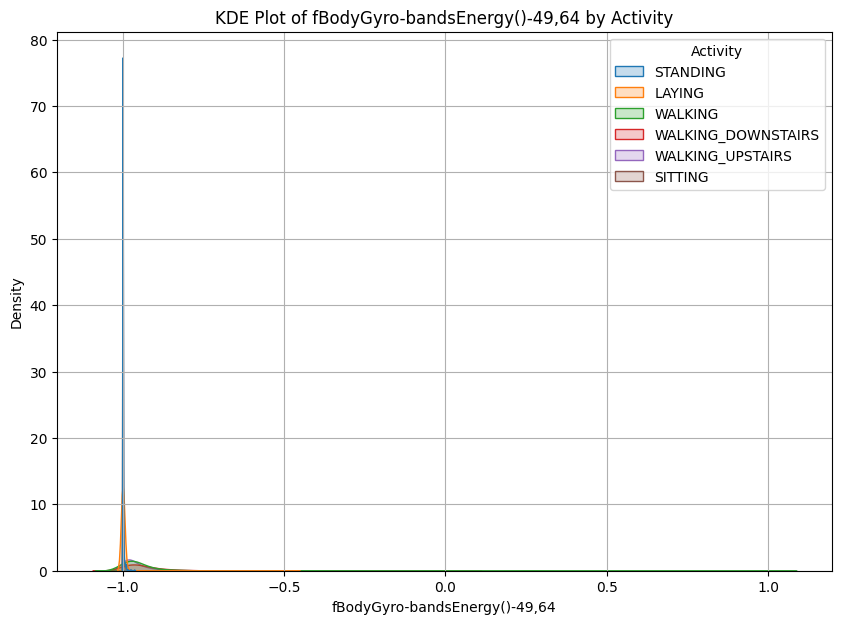

In [118]:
# 556등. fBodyGyro-bandsEnergy()-49,64
feature = 'fBodyGyro-bandsEnergy()-49,64'
target = 'Activity'
kplot(data, feature, target)

In [119]:
# 여러 activity가 많이 겹치는 결과가 도출되었음
# 비슷비슷하게 나와서 큰 설명력을 가지지 않는 것으로 본 듯? => class별로 명확한 차이가 있어야 보이지

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.

#### 1) is_dynamic 추가

In [120]:
# 매핑 사전 생성
acitivity_map = {'STANDING' : 0,
                'SITTING' : 0,
                'LAYING' : 0,
                'WALKING' : 1,
                'WALKING_UPSTAIRS' : 1,
                'WALKING_DOWNSTAIRS' : 1}

# is_dynamic 추가
data['is_dynamic'] = data['Activity'].map(acitivity_map)

# 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [121]:
print(data['is_dynamic'].value_counts())

is_dynamic
0    3234
1    2647
Name: count, dtype: int64


#### 2) 기본모델 생성

In [122]:
# 데이터 분리
target = 'is_dynamic'

x = data.drop(columns=['Activity', 'is_dynamic'])
y = data.loc[:, target]

# 7:3으로 train, val 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify = y, random_state=1)

In [123]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

# 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[970   1]
 [  0 794]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       794

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

In [124]:
# 특성 중요도 추출
importances = model.feature_importances_
feature_names = x_train.columns

# 특성 중요도 데이터프레임 생성
fi_df = plot_feature_importance(importances, feature_names, result_only=True)

# 상위 5개 변수 출력
top_5 = fi_df.head(5)
print("\nTop 5 Important Features:\n", top_5)


Top 5 Important Features:
               feature_name  feature_importance
0  tBodyAccJerk-energy()-X            0.059990
1     fBodyAccJerk-mad()-X            0.049971
2     tBodyAccJerk-mad()-X            0.049912
3     fBodyAccJerk-std()-X            0.049902
4     tBodyAccJerk-std()-X            0.039951


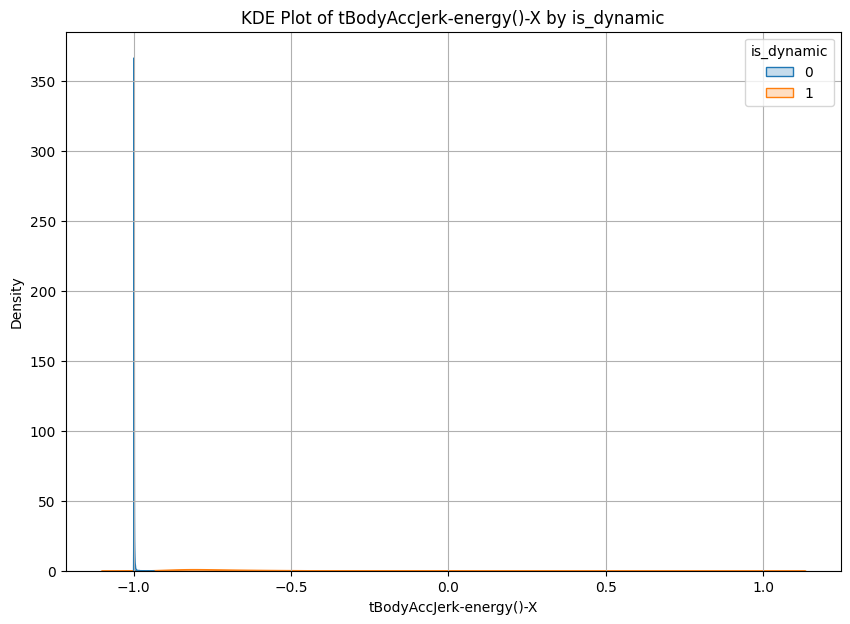

In [125]:
# 1등. tBodyAccJerk-energy()-X
# X축 방향 가속도변화비율 에너지 측정값
feature = 'tBodyAccJerk-energy()-X'
target = 'is_dynamic'
kplot(data, feature, target)

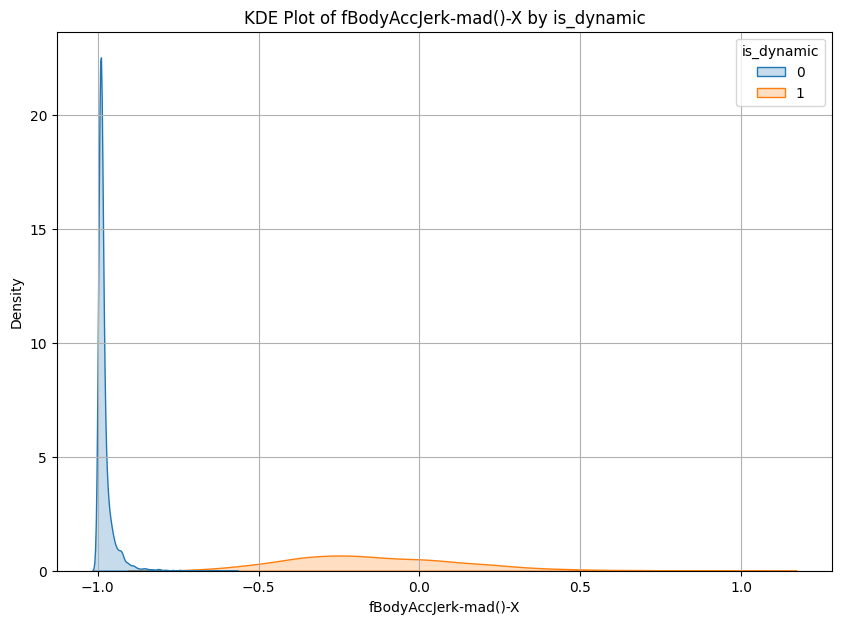

In [126]:
# 2등. fBodyAccJerk-mad()-X
# 고속퓨리에변환을 거친 X축 방향 가속도변화비율 평균절대편차
feature = 'fBodyAccJerk-mad()-X'
target = 'is_dynamic'
kplot(data, feature, target)

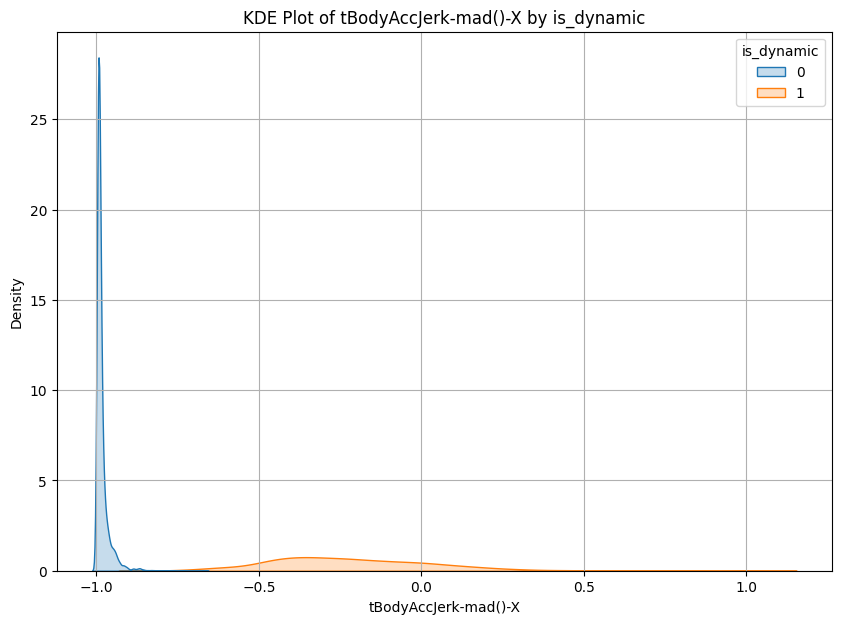

In [127]:
# 3등. tBodyAccJerk-mad()-X
# X축 방향 가속도변화비율 평균절대편차
feature = 'tBodyAccJerk-mad()-X'
target = 'is_dynamic'
kplot(data, feature, target)

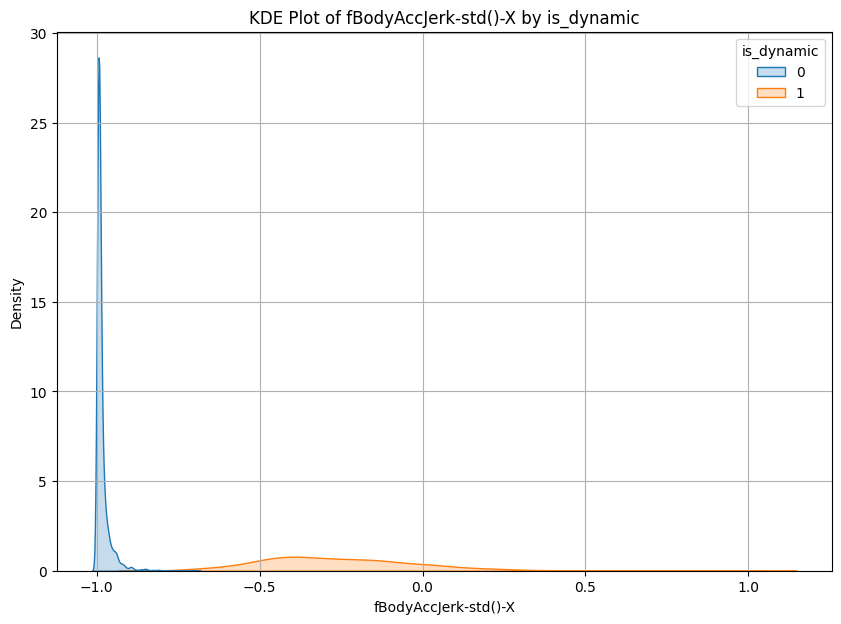

In [128]:
# 4등. fBodyAccJerk-std()-X
# 고속퓨리에변환을 거친 X축 방향 가속도변화비율 표준편차
feature = 'fBodyAccJerk-std()-X'
target = 'is_dynamic'
kplot(data, feature, target)

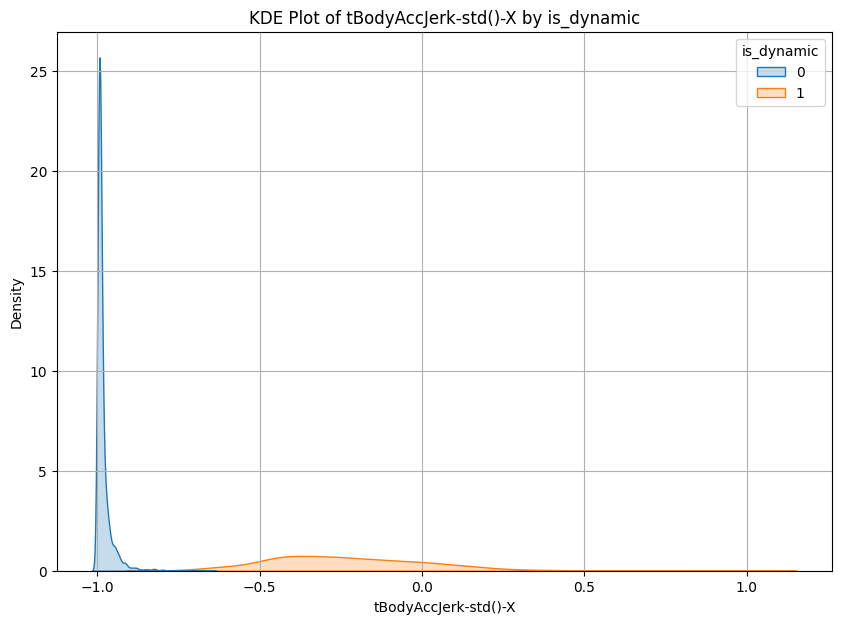

In [129]:
# 5등. tBodyAccJerk-std()-X
# X축 방향 가속도변화비율 표준편차
feature = 'tBodyAccJerk-std()-X'
target = 'is_dynamic'
kplot(data, feature, target)

In [130]:
# 앞서 분석한 상위 5개와 동일한 이유
# 그럼 자이로스코프 센서와 관련된 변수들은 어느정도의 설명력을 가지긴 하는데, 엄청 중요하지도 않은 중간정도라는건가
